In [48]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t
from scipy.stats import cauchy
from scipy.stats import norm

In [49]:
class Distribution(ABC):
    def __init__(self, num_distrib, loc_sampler):
        self.num_distrib = num_distrib
        self.loc_sampler = loc_sampler
        self.locations = self.loc_sampler(size=num_distrib)
        self.distributions = None  # Will be initialized by subclasses

    @abstractmethod
    def _create_distributions(self):
        pass

    def pull_the_lever(self, pos):
        if self.distributions is None:
            self._create_distributions()
        return self.distributions[pos].rvs()  # Draw a sample from the specified distribution
    

class Gaussian(Distribution):
    def __init__(self, num_distrib, sigma, loc_sampler=norm.rvs):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.sigma = sigma  # deviation for gaussian distribution

    def _create_distributions(self):
        self.distributions = [
            norm(scale=self.sigma, loc=loc) for loc in self.locations
        ]


class Student(Distribution):
    def __init__(self, num_distrib, mu, loc_sampler=norm.rvs):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.mu = mu  # degrees of freedom for Student's t distribution

    def _create_distributions(self):
        self.distributions = [
            student_t(df=self.mu, loc=loc) for loc in self.locations
        ]


class Cauchy(Distribution):
    def __init__(self, num_distrib, gamma, loc_sampler=norm.rvs):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.gamma = gamma  # scale parameter for Cauchy distribution

    def _create_distributions(self):
        self.distributions = [
            cauchy(loc=loc, scale=self.gamma) for loc in self.locations
        ]


In [50]:
class Strategy(ABC):
    def __init__(self, num_arms, step_size):
        self.num_arms = num_arms
        self.q_values = np.zeros(num_arms) # Initialize Q-values
        self.counts = np.zeros(num_arms)  # Track visits per arm
        self.step_size = step_size

    @abstractmethod
    def choose_arm(self):
        pass

    @abstractmethod
    def update_q_values(self, arm, reward):
        pass


class EpsilonGreedy(Strategy):
    def __init__(self, num_arms, epsilon=0.1, step_size=lambda count: 1 / count):
        super().__init__(num_arms, step_size=step_size)
        self.epsilon = epsilon

    def choose_arm(self):
        if np.random.random() < self.epsilon:
            # Explore: choose random arm
            return np.random.randint(0, self.num_arms)
        else:
            # Exploit: choose arm with highest estimated reward
            return np.argmax(self.q_values)

    def update_q_values(self, arm, reward):
        self.counts[arm] += 1
        self.q_values[arm] = self.q_values[arm] + self.step_size(self.counts[arm]) * (reward - self.q_values[arm])


class Greedy(EpsilonGreedy):
    def __init__(self, num_arms, step_size=lambda count: 1 / count):
        super().__init__(num_arms, epsilon=0, step_size=step_size)


In [51]:
class BanditTester:
    def __init__(self, distribution: Distribution, strategy: Strategy, distribution_params, strategy_params, num_arms=10, test_num=2000, test_len=1000):
        np.random.seed(42)
        self.distribution = distribution
        self.strategy = strategy
        self.distribution_params = distribution_params
        self.distribution_params["num_distrib"] = num_arms
        self.strategy_params = strategy_params
        self.strategy_params["num_arms"] = num_arms
        self.test_num = test_num
        self.test_len = test_len

    def test(self) -> tuple[list, list]:
        average_rewards = np.zeros(self.test_len)
        optimal_actions = np.zeros(self.test_len)
        for _ in range(self.test_num):
            strategy = self.strategy(**self.strategy_params)  # Create a new strategy instance for each run
            distribution = self.distribution(**self.distribution_params)  # Create a new distribution instance for each run
            optimal_arm = np.argmax(distribution.locations)  # Determine the optimal arm

            for i in range(self.test_len):
                arm = strategy.choose_arm()
                reward = distribution.pull_the_lever(arm)
                strategy.update_q_values(arm, reward)

                average_rewards[i] += reward / self.test_num
                optimal_actions[i] += int(arm == optimal_arm) / self.test_num

        return average_rewards, optimal_actions



In [52]:
distributions = [Gaussian, Student, Student, Cauchy]
distributions_params = [{'sigma': 1}, {'mu': 3}, {'mu': 2}, {'gamma': 1}]
distributions_names = ["Standard Normal", "Student with "+r"$\mu=3$", "Student with "+r"$\mu=2$", "Standard Cauchy"]

In [53]:
def compare_greedy_and_epsilon_greedy(distributions, distributions_params, distributions_names):
    startegies = [Greedy, EpsilonGreedy, EpsilonGreedy]
    strategies_params = [{}, {'epsilon': 0.01}, {'epsilon': 0.1}]

    all_average_rewards, all_optimal_actions = {}, {}

    for distribution, distribution_params, distribution_name in zip(distributions, distributions_params, distributions_names):
        all_average_rewards[distribution_name], all_optimal_actions[distribution_name] = [], []

        for strategy, strategy_params in zip(startegies, strategies_params):
            bandit_tester = BanditTester(distribution, strategy, distribution_params, strategy_params)
            average_rewards, optimal_actions = bandit_tester.test()
    
            all_average_rewards[distribution_name].append(average_rewards)
            all_optimal_actions[distribution_name].append(optimal_actions)

    return all_average_rewards, all_optimal_actions
        

In [54]:
average_rewards, optimal_actions = compare_greedy_and_epsilon_greedy(distributions, distributions_params, distributions_names)

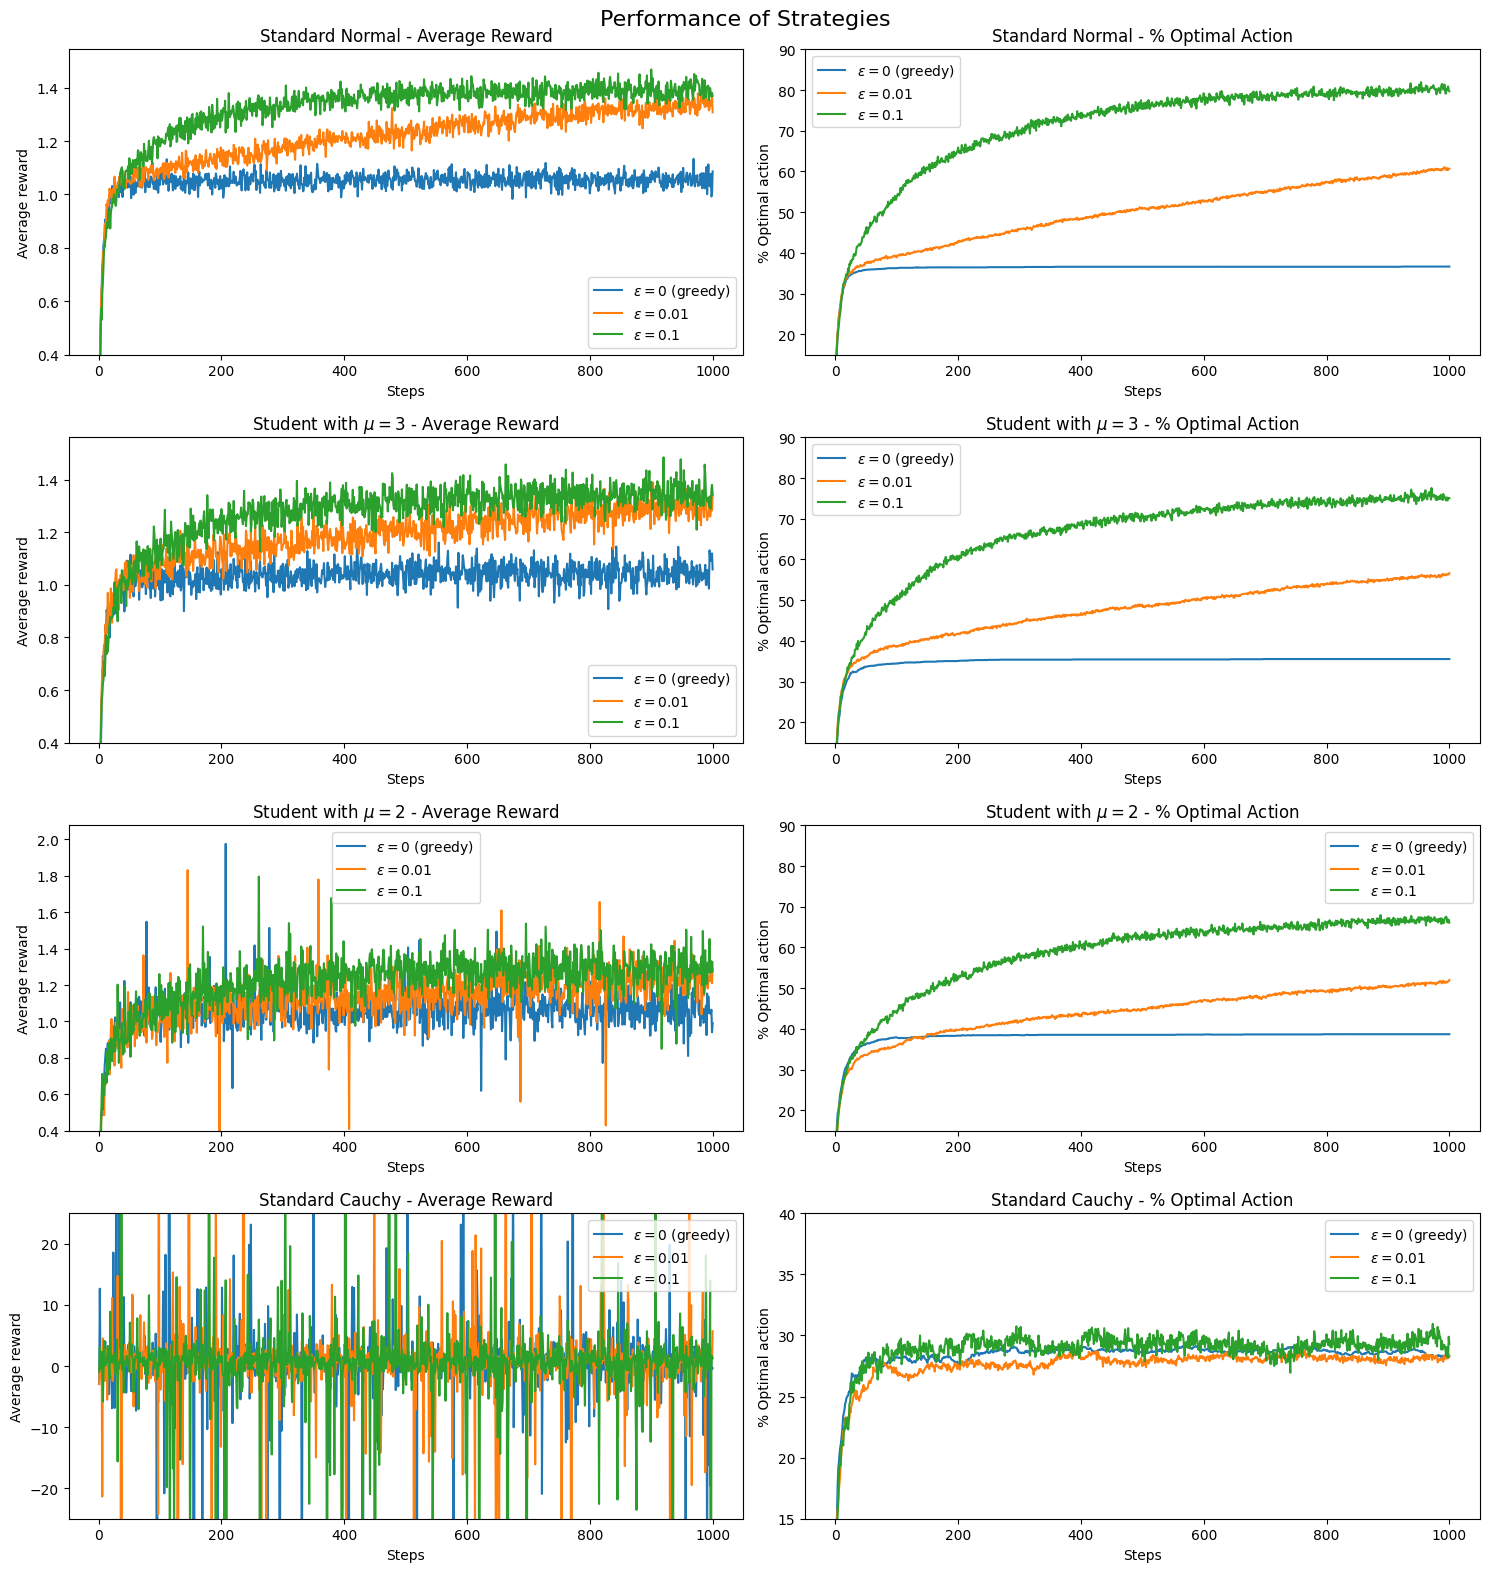

In [56]:
import matplotlib.pyplot as plt

# Define x-axis (steps)
steps = list(range(1, 1001))

# Define labels for epsilon values
epsilon_labels = [r"$\epsilon = 0$ (greedy)", r"$\epsilon = 0.01$", r"$\epsilon = 0.1$"]

# Extract data from dictionaries (already done previously)
# data_avg_rewards = {key: value for key, value in average_rewards.items()}
# data_optimal_actions = {key: value for key, value in optimal_actions.items()}

# Create the figure and individual subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(15, 16))

# Flatten the 2D array of subplots to iterate over them efficiently
axes_flat = axes.flatten()

# Common titles for each plot
fig.suptitle("Performance of Strategies", fontsize=16)
for ax in axes_flat:
    ax.set_xlabel("Steps")

# Loop through each key (distribution)
for i, key in enumerate(average_rewards.keys()):
    # Set titles for the first column (average reward)
    axes_flat[2 * i].set_title(f"{key} - Average Reward")
    # Set titles for the second column (optimal action)
    axes_flat[2 * i + 1].set_title(f"{key} - % Optimal Action")

    # Plot average reward for each epsilon value
    for j, epsilon_label, data in zip(range(3), epsilon_labels, average_rewards[key]):
        axes_flat[2 * i].plot(steps, data, label=epsilon_label)
    axes_flat[2 * i].set_ylabel("Average reward")
    axes_flat[2 * i].set_ylim(0.4, None)  # Set lowest y-axis value to 0.5
    axes_flat[2 * i].legend()

    # Plot optimal actions (convert to percentages) for each epsilon value
    for j, epsilon_label, data in zip(range(3), epsilon_labels, optimal_actions[key]):
        axes_flat[2 * i + 1].plot(steps, [100 * x for x in data], label=epsilon_label)
    axes_flat[2 * i + 1].set_ylabel("% Optimal action")
    axes_flat[2 * i + 1].set_ylim(15, 90)  # Set y-axis limits for optimal action to [15, 90]
    axes_flat[2 * i + 1].legend()

    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        axes_flat[2 * i + 1].set_ylim(15, 40)  # Set x-axis limits for optimal action

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
